## Nobel Twin Familial Cirrhosis Metabolomic Composition Analysis

**Author: Tobin Groth (tgroth@ucsd.edu) and Stephany Z. Flores-Ramos (sflores@ucsd.edu)**

This is the workflow used to analyze the composition of metabolites in the NAFLD/cirrhosis patients. Based on the microbiome notebook `Composition_correlation_analysis.ipynb` written by Anupriya Tripathi (a3tripat@ucsd.edu).

In [16]:
import qiime2
import biom
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os

#for ordering
from scipy import cluster,spatial,stats 
import skbio.diversity.alpha

%matplotlib inline

os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/serum_analysis')

The metadata field 'groups' is used to categorize the probands. 
- G1P is non-NAFLD controls; G1R first degree relatives
- G2P is NAFLD no advanced Fibrosis; G2R first degree relatives
- G3P is NAFLD-cirrhosis; G3R first degree relatives

### Get the number of samples and metabolites

Here the feature table `feature-table-hashed.qza` file was generated in the `itol_tree_generation.ipynb` notebook. 

In [17]:
#load data
table = qiime2.Artifact.load('feature_tables/serum-ft-hashed-matched.qza')
tablepd = table.view(pd.DataFrame)
tablecount = tablepd.T
tablecount.index.names = ['id']

In [18]:
tablecount.head(5)

,TW-CO-002,TW-BT-001,TW-CA-002,TW-BD-002,TW-AV-001,TW-BS-002,TW-BJ-001,TW-CC-002,TW-BU-002,TW-BO-002,...,CIR18-002,CIR41-001,CIR63-002,CIR19-001,CIR5-001,CIR55-002,CIR26-002,CIR5-002,CIR55-001,CIR7-001
id,,,,,,,,,,,,,,,,,,,,,
0004069a1f2c3f2b14511a4f367e485d,55809.1070,141374.9595,14916.9930,14629.0240,66396.5635,110856.6620,54532.7860,6106.9990,55708.8195,58544.1930,...,52941.0850,30491.6290,18869.0830,7493.750,31469.8520,13648.4810,13510.3365,32503.6915,15298.5450,18315.1275
0013ada35a72573fde974722d6f46269,16961.2510,37664.9385,14055.2260,10759.9925,15808.0520,19944.8520,10968.4260,1521.1770,14066.8470,11516.4455,...,9086.6555,26731.5505,6909.4055,23330.377,30378.9275,15351.0115,5407.0380,28023.6515,3773.1720,3538.6200
0074f0d3d22016bcdf28ee53c8a5062b,76560.9505,51482.2780,40373.0870,18470.7590,23415.8245,45154.6000,10543.7155,18521.7740,42652.0710,48116.8700,...,840.0700,245.0250,291.7650,321.048,250.2970,397.1550,571.9335,355.6230,363.6420,526.2325
012ade16945709e69650957b8fdeb021,8627.2465,42985.9195,25469.6935,9440.0045,24054.1530,18580.1280,2033.1125,4845.9370,2993.4050,9767.2055,...,0.0000,106.3120,67.4965,316.206,171.0515,206.2360,282.2875,132.4310,55.2585,184.4635
015bcc773d2fe77d5ddf3533aff00a9f,9663.3085,944092.9690,152745.3160,1046.6465,521873.9165,208126.6295,125.6375,8067.5265,11224.1400,298.7875,...,347.2560,245.0465,175.2000,271.908,455.9895,187.8240,320.2720,143.5105,85.7150,249.0520


In [19]:
#get all metabolites
obs_arr= tablecount.index 
len(obs_arr) #number of metabolites

1847

In [20]:
#get sample ids
sample_arr = tablecount.columns
len(sample_arr) #number of samples in the table

167

### Creating a dictionary with the list of samples in each disease group

In [21]:
#load the metadata
md = pd.read_table('../metadata-matched.tsv', sep='\t', index_col=0)
md.index.rename('id', inplace=True)
md.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
id,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [22]:
md.ATTRIBUTE_groups.value_counts()

G1P    48
G1R    37
G3R    30
G3P    22
G2P    16
G2R    14
Name: ATTRIBUTE_groups, dtype: int64

In [23]:
#make a dictionary with list of samples in each group

gp_to_samples={}
gp_list = ['G1P', 'G2P', 'G3P', 'G1R', 'G2R', 'G3R']

gp_to_samples['G1P']=[idx for idx in md[md.ATTRIBUTE_groups=='G1P'].index if idx in sample_arr]
gp_to_samples['G1R']=[idx for idx in md[md.ATTRIBUTE_groups=='G1R'].index if idx in sample_arr]
gp_to_samples['G2P']=[idx for idx in md[md.ATTRIBUTE_groups=='G2P'].index if idx in sample_arr]
gp_to_samples['G2R']=[idx for idx in md[md.ATTRIBUTE_groups=='G2R'].index if idx in sample_arr]
gp_to_samples['G3P']=[idx for idx in md[md.ATTRIBUTE_groups=='G3P'].index if idx in sample_arr]
gp_to_samples['G3R']=[idx for idx in md[md.ATTRIBUTE_groups=='G3R'].index if idx in sample_arr]

### Getting a dataframe with the classification information

In [24]:
#get the class hierarchial annotations of the metabolites
#tablet = qiime2.Artifact.load('')
#tablecpd = tablet.view(pd.DataFrame)
tablecpd = pd.read_csv('classified-feature-data.tsv',sep='\t',index_col=0)
print(tablecpd.shape)
tablecpd.head(3)

(1847, 13)


,#featureID,csi_smiles,ms2_smiles,ms2_compound,ms2_adduct,table_number,smiles,annotation_type,kingdom,superclass,class,subclass,direct_parent
id,,,,,,,,,,,,,
da5dc9007216de85908619b0d8d6c065,395,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,NaN,NaN,NaN,1,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
b5a7b5651a9dd589ebba875701732d11,4673,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,NaN,NaN,NaN,1,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
5a307cd7a787f5b3269a7d6c0175fb2e,2513,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,NaN,NaN,NaN,1,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified


In [25]:
tablecpd["hierarchy"] = tablecpd["kingdom"] +"; "+ tablecpd["superclass"] +"; "+ tablecpd["class"] +"; "+ tablecpd["subclass"] +"; "+ tablecpd["direct_parent"]

In [26]:
tableclpd = tablecpd[['hierarchy']]
tableclpd.head()

,hierarchy
id,
da5dc9007216de85908619b0d8d6c065,unclassified; unclassified; unclassified; uncl...
b5a7b5651a9dd589ebba875701732d11,unclassified; unclassified; unclassified; uncl...
5a307cd7a787f5b3269a7d6c0175fb2e,unclassified; unclassified; unclassified; uncl...
498af6ef399e0766ab141f7e0850f255,Organic compounds; Lipids and lipid-like molec...
acbf29f7bd5e973284e8764f1ca8666e,unclassified; unclassified; unclassified; uncl...


In [27]:
#add the hierarchial information to the count feature table
tableclassified = pd.merge(tablecount,
                 tableclpd,
                 on='id', 
                 how='left')

In [28]:
print(tableclassified.shape)
tableclassified.head(3)

(1847, 168)


,TW-CO-002,TW-BT-001,TW-CA-002,TW-BD-002,TW-AV-001,TW-BS-002,TW-BJ-001,TW-CC-002,TW-BU-002,TW-BO-002,...,CIR41-001,CIR63-002,CIR19-001,CIR5-001,CIR55-002,CIR26-002,CIR5-002,CIR55-001,CIR7-001,hierarchy
id,,,,,,,,,,,,,,,,,,,,,
0004069a1f2c3f2b14511a4f367e485d,55809.1070,141374.9595,14916.993,14629.0240,66396.5635,110856.662,54532.7860,6106.999,55708.8195,58544.1930,...,30491.6290,18869.0830,7493.750,31469.8520,13648.4810,13510.3365,32503.6915,15298.545,18315.1275,unclassified; unclassified; unclassified; uncl...
0013ada35a72573fde974722d6f46269,16961.2510,37664.9385,14055.226,10759.9925,15808.0520,19944.852,10968.4260,1521.177,14066.8470,11516.4455,...,26731.5505,6909.4055,23330.377,30378.9275,15351.0115,5407.0380,28023.6515,3773.172,3538.6200,Organic compounds; Lipids and lipid-like molec...
0074f0d3d22016bcdf28ee53c8a5062b,76560.9505,51482.2780,40373.087,18470.7590,23415.8245,45154.600,10543.7155,18521.774,42652.0710,48116.8700,...,245.0250,291.7650,321.048,250.2970,397.1550,571.9335,355.6230,363.642,526.2325,Organic compounds; Benzenoids; Benzene and sub...


In [29]:
tableclassified.reset_index().to_csv('composition_analysis/serum-ft-hashed-wclassification.csv', index= False)

### Get the frequency at the direct parent level

In [30]:
tablepd = pd.read_csv('composition_analysis/serum-ft-hashed-wclassification.csv', index_col= 0)

In [31]:
#checking for missing taxonomic information
len(tablepd[tablepd['hierarchy']=="unclassified; unclassified; unclassified; unclassified; unclassified"])

868

In [32]:
#removing the unclassified features
indexNames = tablepd[tablepd['hierarchy']=="unclassified; unclassified; unclassified; unclassified; unclassified"].index
tablepd.drop(indexNames , inplace=True)
tablepd.shape

(979, 168)

In [33]:
#get all metabolites 
obs_arr= tablepd.index 
len(obs_arr) #number of metabolites

979

In [34]:
#get sample ids
sample_arr = tablepd.columns
len(sample_arr)-1 #number of samples in the table, not counting the hierarchy

167

In [35]:
# to store average frequencies of bacterial groups across samples in a group at the direct parent level
t1=time.time()
gp_to_taxa={} 
for gp in gp_list: #for each group
    gp_to_taxa[gp]={}

for gp in gp_list:
    for sample in gp_to_samples[gp]: #for sample i in the whole sample list (e.g. cirrhosis,TW)
        weighted_sampotus=np.zeros(len(obs_arr)) #creates a lost with zeros that's as long as the num of metabolites 
        sample_otu=np.array(tablepd[sample]) #getting an array of all the feature counts per sample
        otu_freqsum=np.sum(sample_otu) #sum of all the feature counts for one sample
        if otu_freqsum == 0:
            continue
        else:
            nz_ind=sample_otu!=0
            for i in range(len(nz_ind)):
                if nz_ind[i]:
                    weighted_sampotus[i]=sample_otu[i]/float(otu_freqsum) #normalizing freq. of an otu in sample with the sum of frequencies of all otus in the sample
                    taxa = tablepd['hierarchy'][i]
                    taxa_bins=[]
                    for q in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into
                        taxa_bins.append(taxa)
                        #taxa.pop()
                    for taxa_bin in taxa_bins: #creating a dict of dict to store weights for each otu's taxa bin within each group
                        if taxa_bin not in gp_to_taxa[gp].keys():
                            gp_to_taxa[gp][taxa_bin]=weighted_sampotus[i]
                        else:
                            gp_to_taxa[gp][taxa_bin]+=weighted_sampotus[i] 
    for taxa_bin in gp_to_taxa[gp].keys():
        gp_to_taxa[gp][taxa_bin]=gp_to_taxa[gp][taxa_bin]/len(gp_to_samples[gp]) #averaging for all samples within an group
t2=time.time()
print(t2-t1)  

13.661065816879272


In [36]:
#filter taxlevel: kingdom level=0; phylum level=1 
#these are functions
def filter_tax(gp_to_taxa, taxlevel):
    f_gp_to_taxa={}
    for gp in gp_list:
        f_gp_to_taxa[gp]={}
        for taxa in gp_to_taxa[gp].keys():
            if len(taxa.split(';'))==taxlevel+1: #this will only work for the direct direct parent level
                f_gp_to_taxa[gp][taxa]=gp_to_taxa[gp][taxa]
    return f_gp_to_taxa

#normalize empo levels to sum to 1
def norm(f_gp_to_taxa):
    nf_gp_to_taxa={}
    for gp in gp_list:
        nf_gp_to_taxa[gp]={}
        tot=sum(f_gp_to_taxa[gp].values())
        for taxa in f_gp_to_taxa[gp].keys():
            nf_gp_to_taxa[gp][taxa]=f_gp_to_taxa[gp][taxa]/tot
    return nf_gp_to_taxa

In [37]:
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 4))).fillna(0).to_csv('composition_analysis/directparent_groupwise.csv', sep=',')

In [58]:
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 3))).fillna(0).to_csv('composition_analysis/subclass_groupwise.csv', sep=',')

### Frequency at kingdom, superclass, class, and subclass level

In [39]:
tablepd = pd.read_csv('composition_analysis/serum-ft-hashed-wclassification.csv', index_col= 0)

#get classification information for the other taxonomic levels
tablepd[['kingdom','superclass','class','subclass','directparent']] = tablepd.hierarchy.str.split(';', expand=True)

In [40]:
# to store average frequencies of bacterial groups across samples in a group at different hierarchial levels
def get_group_freqn(tablepd,tax_level):
    
    indexNames = tablepd[tablepd[tax_level]==" unclassified"].index
    tablepd.drop(indexNames , inplace=True)
    
    #subclass
    tablepd['subclass']=tablepd['kingdom']+"; "+ tablepd['superclass']+"; "+ tablepd['class']+"; "+ tablepd['subclass']
    #class
    tablepd['class']=tablepd['kingdom']+"; "+ tablepd['superclass']+"; "+ tablepd['class']
    #superclass
    tablepd['superclass']=tablepd['kingdom']+"; "+ tablepd['superclass']
    #kingdom
    tablepd['kingdom']=tablepd['kingdom']
    
    gp_to_taxa={} 
    for gp in gp_list: #for each group
        gp_to_taxa[gp]={}

    for gp in gp_list:
        for sample in gp_to_samples[gp]: #for sample i in the whole sample list (e.g. cirrhosis,TW)
            weighted_sampotus=np.zeros(len(obs_arr)) #creates a lost with zeros that's as long as the num of metabolites 
            sample_otu=np.array(tablepd[sample]) #getting an array of all the feature counts per sample
            otu_freqsum=np.sum(sample_otu) #sum of all the feature counts for one sample
            if otu_freqsum == 0:
                continue
            else:
                nz_ind=sample_otu!=0
                for i in range(len(nz_ind)):
                    if nz_ind[i]:
                        weighted_sampotus[i]=sample_otu[i]/float(otu_freqsum) #normalizing freq. of an otu in sample with the sum of frequencies of all otus in the sample
                        taxa = tablepd[tax_level][i] #change this to hierarchial level
                        taxa_bins=[]
                        for q in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into
                            taxa_bins.append(taxa)
                            #taxa.pop()
                        for taxa_bin in taxa_bins: #creating a dict to store weights for each otu's taxa bin within each group
                            if taxa_bin not in gp_to_taxa[gp].keys():
                                gp_to_taxa[gp][taxa_bin]=weighted_sampotus[i]
                            else:
                                gp_to_taxa[gp][taxa_bin]+=weighted_sampotus[i] 
        for taxa_bin in gp_to_taxa[gp].keys():
            gp_to_taxa[gp][taxa_bin]=gp_to_taxa[gp][taxa_bin]/len(gp_to_samples[gp]) #averaging for all samples within an group
    


    return gp_to_taxa 

In [41]:
gp_to_taxa_sbc=get_group_freqn(tablepd,"subclass")
#gp_to_taxa_c=get_group_freqn(tablepd,"class")
#gp_to_taxa_spc=get_group_freqn(tablepd,"superclass")
#gp_to_taxa_k=get_group_freqn(tablepd,"kingdom")

#note to get this to work, I had to reload tablepd

In [43]:
#save average frequencies at different taxonomic levels

#pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa_k, 0))).fillna(0).to_csv('tables/composition_analysis_tables/kingdom_groupwise.csv', sep=',')
#pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa_spc, 1))).fillna(0).to_csv('tables/composition_analysis_tables/superclass_groupwise.csv', sep=',')
#pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa_c, 2))).fillna(0).to_csv('tables/composition_analysis_tables/class_groupwise.csv', sep=',')
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa_sbc, 3))).fillna(0).to_csv('composition_analysis/subclass_groupwise.csv', sep=',')

## 1. comparing the gut microbial composition of non-NAFLD controls (G1P) vs. NAFLD without advanced fibrosis (G2P) vs. NAFLD-cirrhosis (G3P)

Only plotting top n taxa, rest in 'others'. The rationale is to represent top taxonomic/hierarchial groups and keep the composition of 'others' category consistent.

In [44]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize'] = (5.0, 10.0)

In [45]:
#calculate top n taxa for a particular level
def toptaxa(nfgptaxa,numbertaxa):
    wt_tup=[]
    top_taxa=[]
    for gp in nfgptaxa: #lop to make a tupule of (wt, taxa)
        for taxa in nfgptaxa[gp].keys():
            wt_tup.append((nfgptaxa[gp][taxa],taxa))
    wt_tup=sorted(wt_tup, reverse=True)
    
    for tup in wt_tup: #getting top taxa
        if len(top_taxa)<numbertaxa and tup[1] not in top_taxa:
            top_taxa.append(tup[1])
    return top_taxa

In [46]:
#group the taxa which are not in top n taxa u 'others'
def add_others2(nfgptaxa, top_taxa):
    gp_to_taxa_rev={}
    for gp in nfgptaxa:
        gp_to_taxa_rev[gp]={}
        others=0
        for taxa in nfgptaxa[gp].keys():
            if taxa not in top_taxa:
                others+=nfgptaxa[gp][taxa]
            else:
                gp_to_taxa_rev[gp][taxa]=nfgptaxa[gp][taxa]
            gp_to_taxa_rev[gp]['others']=others
    return gp_to_taxa_rev

In [47]:
#make a dictionary for the colors to use on the plot
def top_color(color_list, top_taxa):
    top_color = {top_taxa[i]: color_list[i] for i in range(len(top_taxa))}
    top_color.update( {'others' : '#bab0ac'} )
    return top_color

In [48]:
#this is to assign more colors to the plot
seed = ['#910074','#e8e700','#0023bf','#5eff9f','#ff2563','#356f00','#bc92ff',
        '#ff7539','#0099b6','#ff768f','#002110','#daffde','#001338','#ffb0c2',
        '#370600']

In [51]:
#new plotting function that takes numbertaxa (number of taxa to be plotted i.e. top n) intead of cutoff (bottom 2% etc.) like in previous figures
def plot_gp2(gp_to_taxa, taxlevel, cnames, numbertaxa, gplist=['G1P', 'G1R', 'G2P', 'G2R', 'G3P', 'G3R'], 
             lablist = None, color='random', wide = False):
    
    fgptaxa=filter_tax(gp_to_taxa, taxlevel) #get the taxa info
    nfgptaxa=norm(fgptaxa) #normalize the counts
    top_taxa=toptaxa(nfgptaxa,numbertaxa) #get the taxa that are most represented
    onfgptaxa=add_others2(nfgptaxa, top_taxa) #collapse all other taxa to others
    onfgptaxa_df = pd.DataFrame(onfgptaxa).fillna(0) #make a df
    topc = top_color(cnames,top_taxa) #get distinct colors for each element
    
    #save source
    #onfgptaxa_df.to_csv('tables/composition_analysis_tables/source_data_top10composition_groups_wrels.csv', sep=',')
    #onfgptaxa_df.to_csv('tables/composition_analysis_tables/source_data_top10composition_groups.csv', sep=',')
    #onfgptaxa_df.to_csv('tables/composition_analysis_tables/source_data_top12composition_groups.csv', sep=',')
    onfgptaxa_df.to_csv('composition_analysis/source_data_top12composition_groups_wrels.csv', sep=',')

    from scipy.cluster import hierarchy
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist, squareform

    gp_list2 = gplist
    fig = plt.figure()
    
    if lablist == None:
        lablist = gp_list2
    ind=np.arange(0, len(gp_list2)/2, step=0.5)
    count_ind=0
    taxa_list=[]

    #plotting barplot & legend
    ax = fig.add_subplot(1, 1, 1)
    
    
    for gp in gp_list2: #for each group
        taxa_sorted=sorted(onfgptaxa[gp].keys())
        tmp=[]
        count_tmp=0
        for taxa in taxa_sorted:
            tmp.append(onfgptaxa[gp][taxa])
            if count_tmp==0:
                bottom=0
            else:
                bottom+=tmp[count_tmp-1] #i think this stacks it 
            if taxa not in taxa_list:
                taxa_list.append(taxa)
                lab=taxa
            else:
                lab=''
            if color=='random':
                p1=plt.bar(ind[count_ind],tmp[count_tmp],width=0.4,
                           bottom=bottom, label=lab) #, color=colors_taxa[taxa])
                count_tmp+=1 
            elif color=='assigned':
                p1=plt.bar(ind[count_ind],tmp[count_tmp],width=0.4, color=topc[taxa], 
                           bottom=bottom, label=lab) #, color=colors_taxa[taxa])color=cnames[taxa], 
                count_tmp+=1 
        count_ind+=1 

    handles, labels = ax.get_legend_handles_labels()
    plt.ylabel('relative abundance of hierarchial group',fontsize=20)
    plt.xticks(ind, lablist, rotation=0, fontsize=25)
    plt.xticks(fontsize=18)
    plt.ylim([0,1])
    ax.set
    
    try:
        import operator
        hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
        handles2, labels2 = zip(*hl)
        ax.legend(handles2, labels2, loc='best', bbox_to_anchor=(-1, 1),fontsize=20)
    except:
        print('legend problem')
        
    return plt

### composition plot @ direct parent level

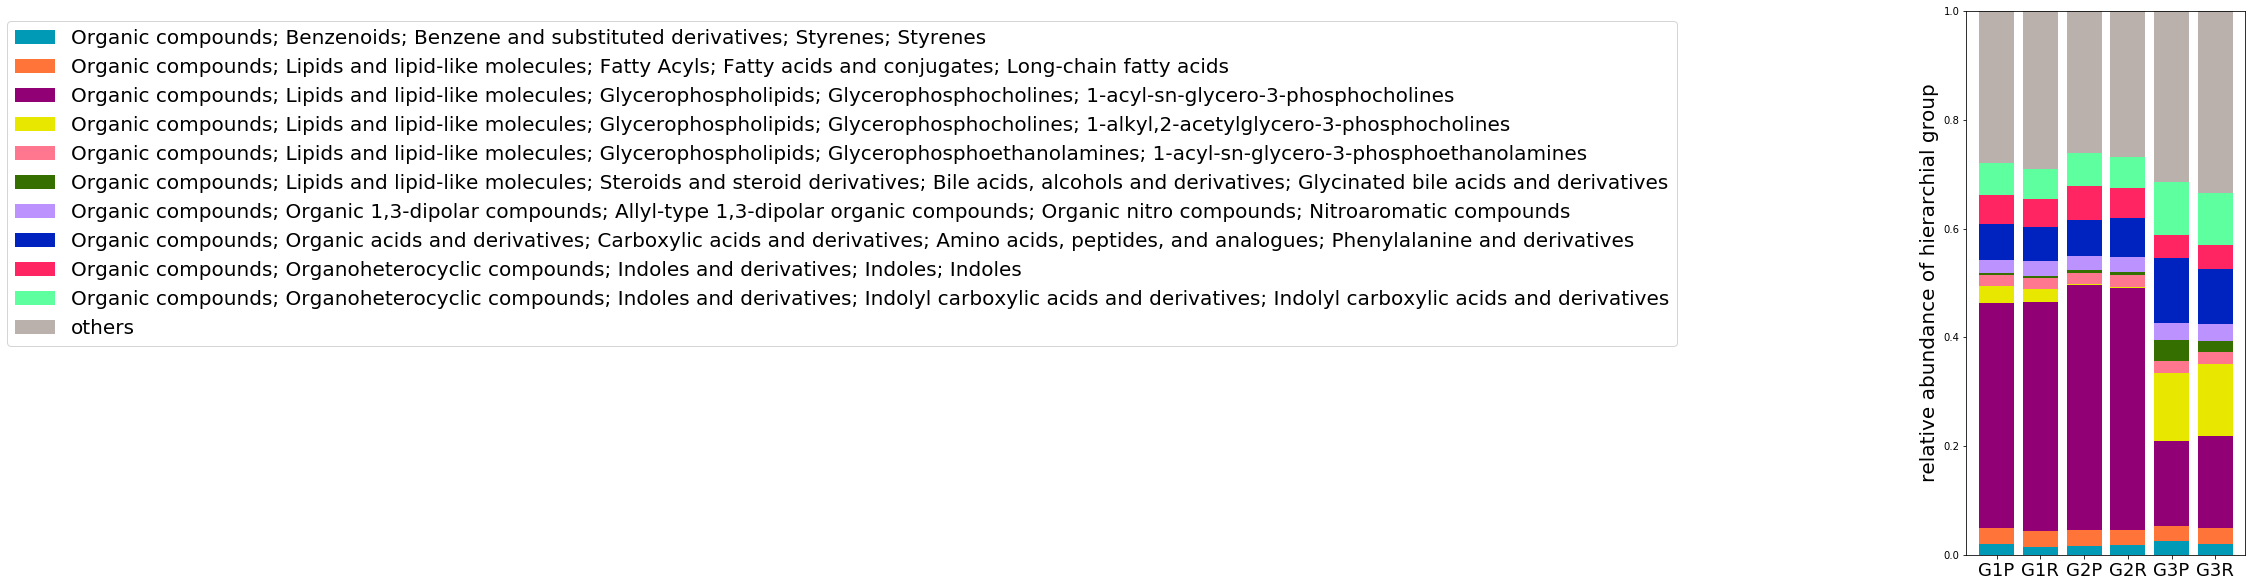

In [52]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=10, gplist=['G1P', 'G1R', 'G2P', 'G2R', 'G3P', 'G3R'], 
              color='assigned', wide = True)
#bar.savefig('figures/direct_parent_top10_g1p_g2p_g3p_R1_andrels.pdf', bbox_to_inches='tight')

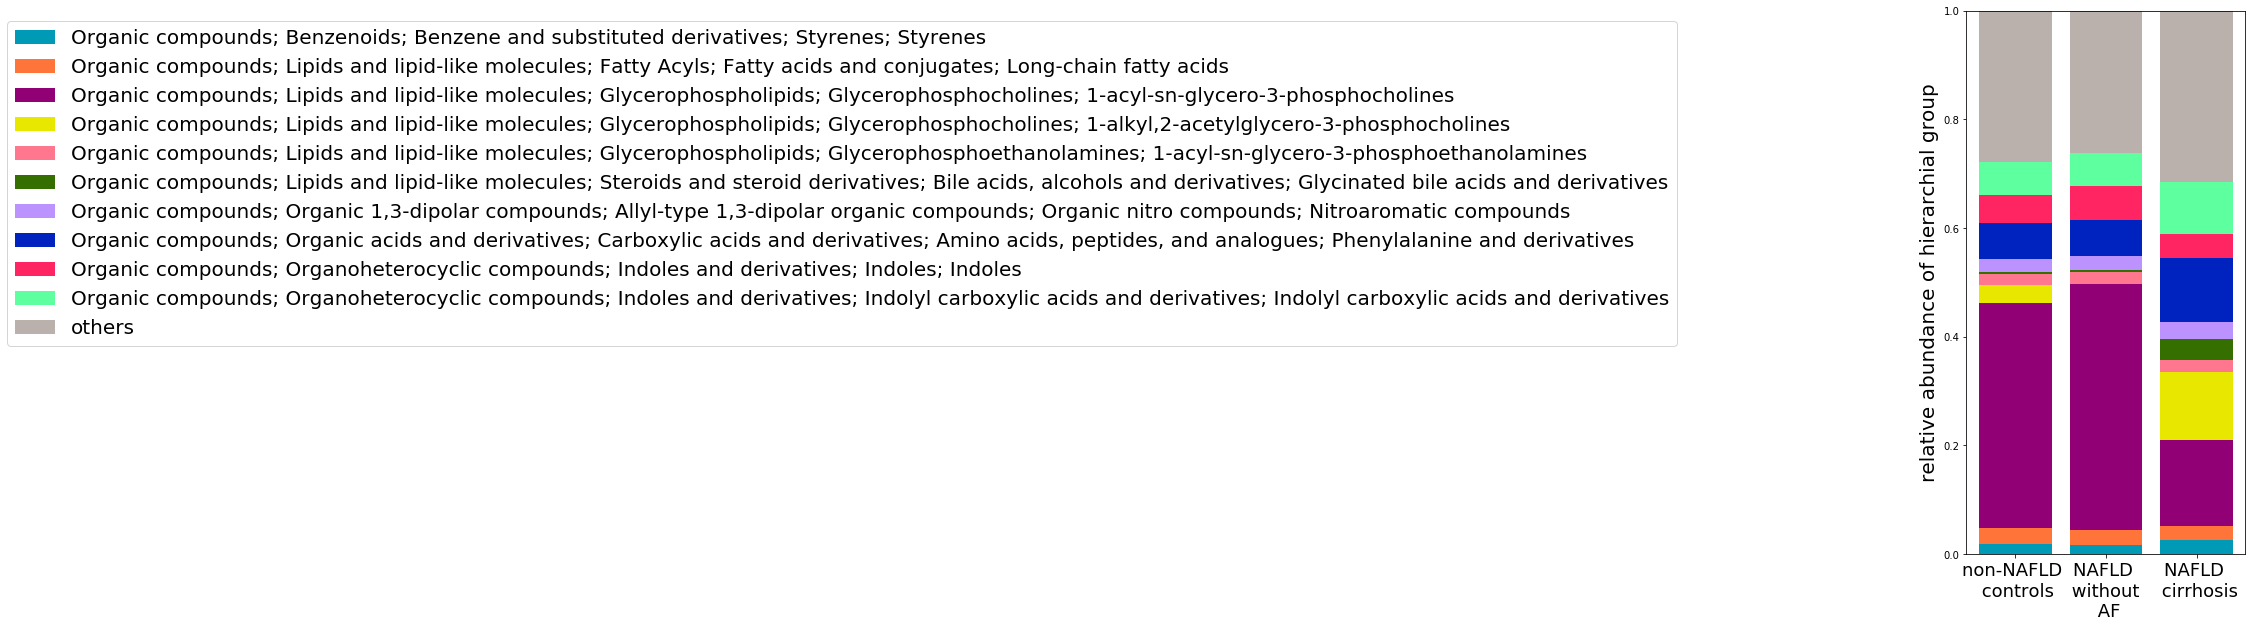

In [53]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=10, gplist=['G1P', 'G2P', 'G3P'], 
              color='assigned', lablist=['non-NAFLD \n controls', 'NAFLD \n without \n AF','NAFLD \n cirrhosis'], wide = False)
#bar.savefig('figures/direct_parent_top10_g1p_g2p_g3p_R1.pdf', bbox_to_inches='tight')

** observations from G1P vs. G3P**
- there are more bile acids in the cirrhosis patient!
- 1-acyl-sn-glycero-3-phosphocholines are present in control and cirrhosis probands but not NAFLD w/o AF
- There's a lot of 1-alhayl,2-acetylglycero-3-phosphocholines in the NAFLD w/o AF and not in the other probands
- other things look pretty stable!

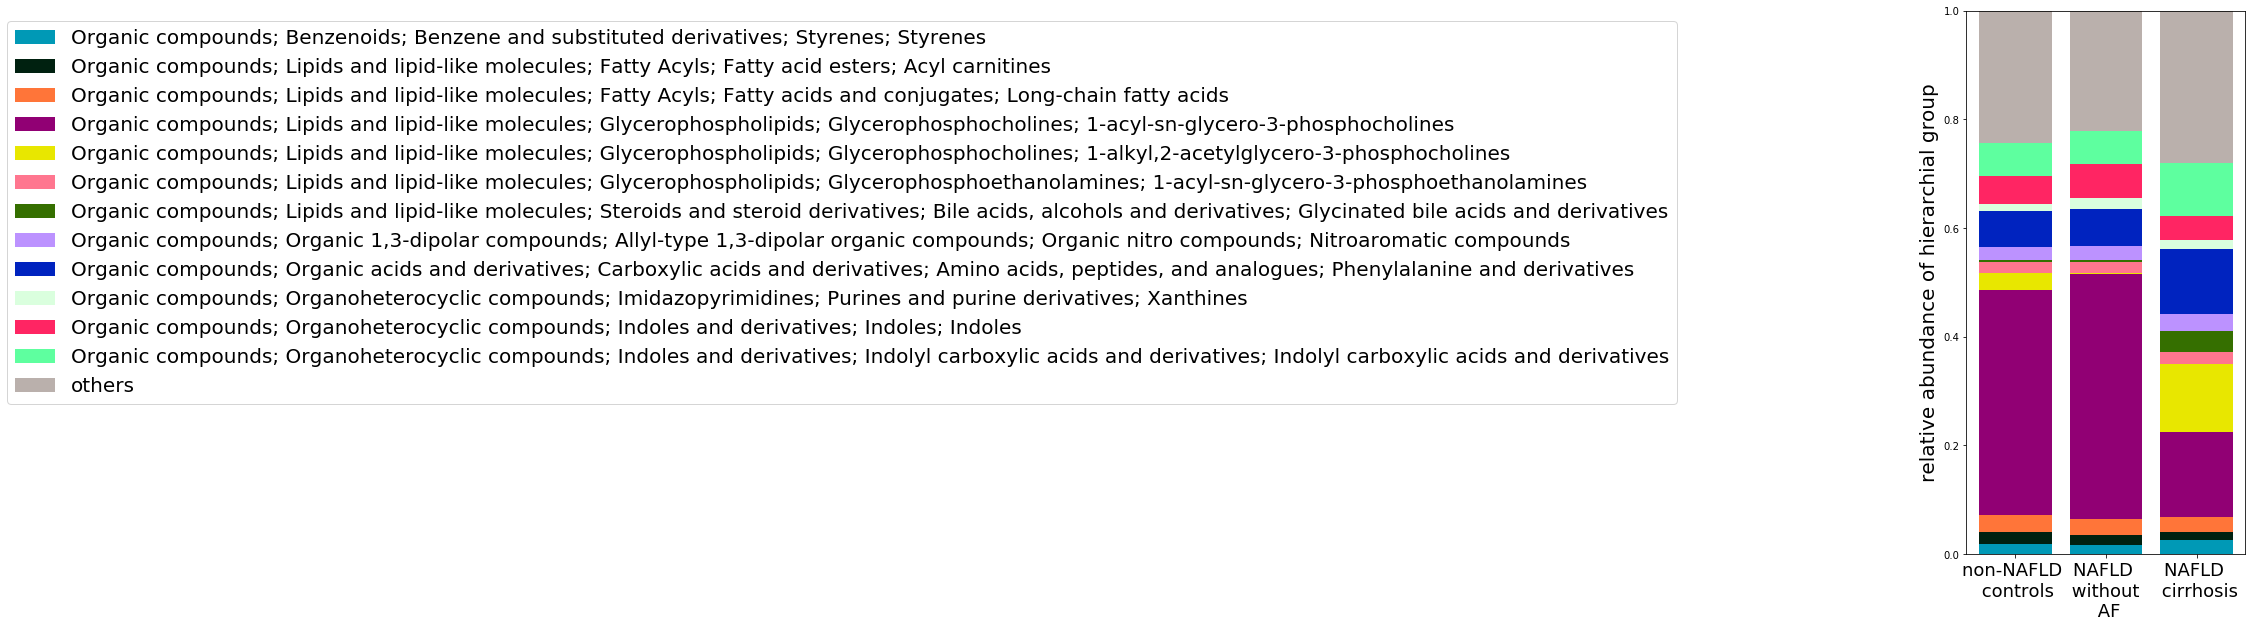

In [54]:
bar = plot_gp2(gp_to_taxa, 4,cnames=seed, numbertaxa=12, gplist=['G1P', 'G2P', 'G3P'], 
              color='assigned', lablist=['non-NAFLD \n controls', 'NAFLD \n without \n AF','NAFLD \n cirrhosis'], wide = False)
bar.savefig('composition_analysis/figures/direct_parent_top12_g1p_g2p_g3p_R1.pdf', bbox_to_inches='tight')